# World Values Survey - EDA Notebook

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings

warnings.simplefilter(action='ignore', category=Warning)
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
palette = {'dark_navy': '#001253', 'mid_blue': '#3E6D9C', 'mid_orange': '#FD841F', 'light_blue': '#7FC7D9',
           'dark_orange': '#E14D2A', 'dark_purple': '#2E073F', 'dark_green': '#1A5319'}
palette2 = {'green_teel': '#24A19C', 'lilach': "#9D65C9", 'peach': '#FE7E6D', 'banana': "#FFB961"}

In [3]:
df = pd.read_csv("Project_parts_1_2/WVS_Cross-National_Wave_7_csv_v6_.csv")
df.head()

,B_COUNTRY_ALPHA,G_TOWNSIZE,H_URBRURAL,AGE,EDUCATION,INCOME_LEVEL,SACSECVAL,RESEMAVAL,DEFIANCE,DISBELIEF,RELATIVISM,SCEPTICISM,AUTONOMY,EQUALITY,CHOICE,VOICE
0,AND,5,1,60,3,5,0.287062,0.413241,0.38258,0.666667,0.0,0.09900,0.666667,0.690000,0.296296,0.000
1,AND,3,1,47,7,9,0.467525,0.519722,0.22000,1.000000,0.0,0.65010,0.000000,0.690000,0.888889,0.500
2,AND,3,1,48,7,5,0.425304,0.692917,0.44000,0.886667,0.0,0.37455,1.000000,0.690000,0.666667,0.415
3,AND,3,1,62,2,4,0.556170,0.481065,0.57458,1.000000,0.0,0.65010,0.000000,0.916667,0.592593,0.415
4,AND,3,1,49,2,4,0.458949,0.475741,0.57458,0.886667,0.0,0.37455,0.333333,0.690000,0.629630,0.250


In [4]:
discrete_cols = ['AGE', 'EDUCATION', 'INCOME_LEVEL']
cont_cols = ["SACSECVAL", "RESEMAVAL", "DEFIANCE", "DISBELIEF", "RELATIVISM", "SCEPTICISM", "AUTONOMY", "EQUALITY",
             "CHOICE", "VOICE"]
df[discrete_cols].AGE.value_counts().sort_index(ascending=True)
df[discrete_cols].INCOME_LEVEL.value_counts().sort_index(ascending=True)
df[discrete_cols].EDUCATION.value_counts().sort_index(ascending=True)
disb_med = df.DISBELIEF.median()
df['ReligCountry'] = df['DISBELIEF'].apply(lambda x: 1 if x <= disb_med else 0)

mask_age = df['AGE'] >= 0
mask_edu = df['EDUCATION'] >= 0
mask_inc = df['INCOME_LEVEL'] >= 0
clean_df = df[mask_age & mask_edu & mask_inc].dropna()
removed_df = df[~(mask_age & mask_edu & mask_inc)]
relig_df = clean_df[clean_df["ReligCountry"] == 1]
sec_df = clean_df[clean_df["ReligCountry"] == 0]

In [5]:
clean_df.groupby("ReligCountry").SACSECVAL.describe()

,count,mean,std,min,25%,50%,75%,max
ReligCountry,,,,,,,,
0,40725.0,0.473892,0.152556,0.096667,0.360000,0.470000,0.581667,1.000000
1,45918.0,0.272930,0.138706,0.000000,0.165833,0.262222,0.373611,0.776944


In [6]:
removed_df.B_COUNTRY_ALPHA.value_counts()

B_COUNTRY_ALPHA
GBR    620
NLD    486
MAC    222
JPN    157
BRA    143
      ... 
TWN      2
MMR      2
NIC      1
BGD      1
VEN      1
Name: count, Length: 59, dtype: int64

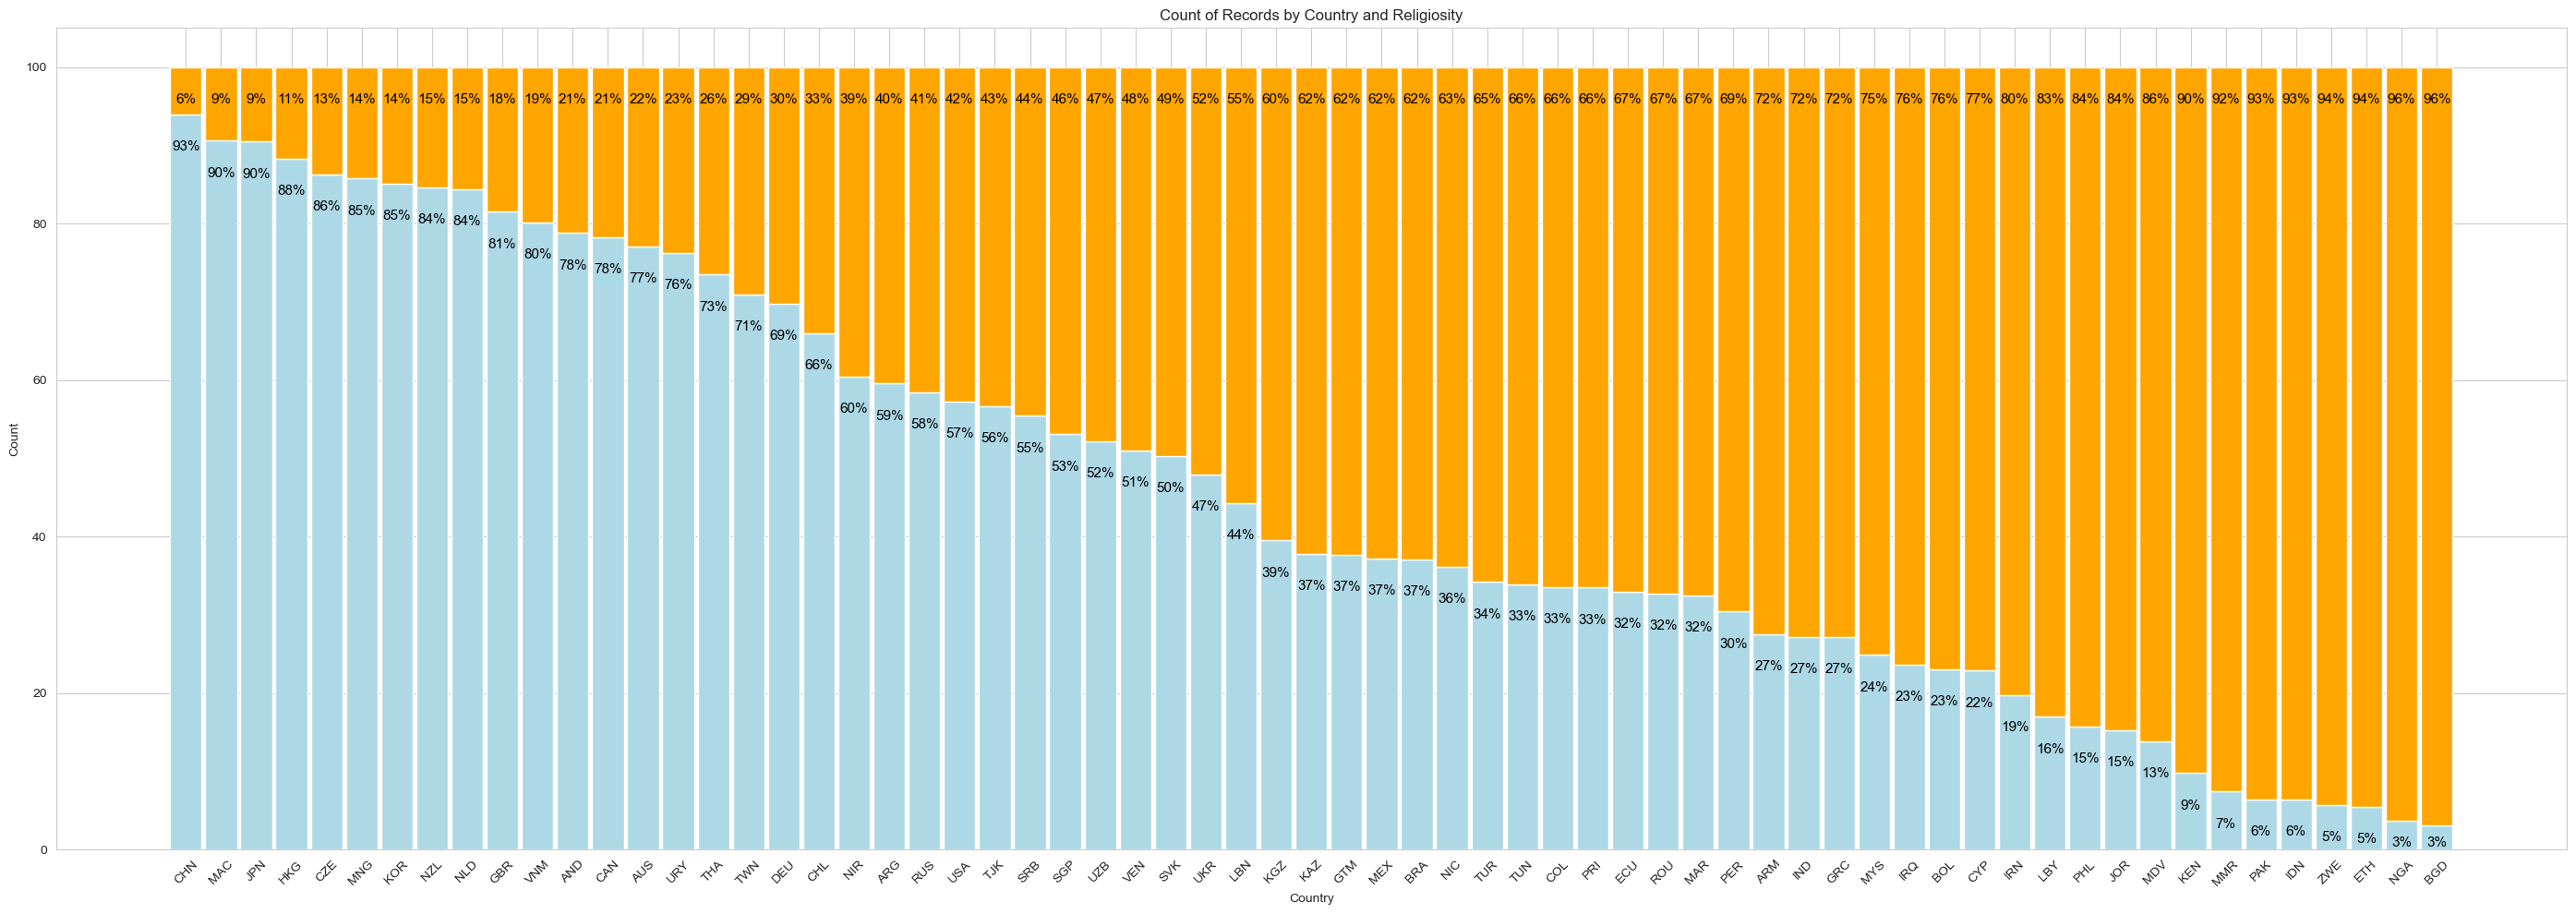

In [7]:
grouped_df = clean_df.groupby(['B_COUNTRY_ALPHA', 'ReligCountry']).size().reset_index(name='count')
total_count_per_country = grouped_df.groupby('B_COUNTRY_ALPHA')['count'].transform('sum')
grouped_df['percentage'] = grouped_df['count'] / total_count_per_country * 100
pivot_df = grouped_df.pivot(index='B_COUNTRY_ALPHA', columns='ReligCountry', values='percentage').fillna(0)
pivot_df = pivot_df.sort_values(by=0, ascending=False)

plt.figure(figsize=(28, 10))
bars_0 = plt.bar(pivot_df.index, pivot_df[0], label='Non-religious', color='lightblue', width=0.9)
bars_1 = plt.bar(pivot_df.index, pivot_df[1], bottom=pivot_df[0], label='Religious', color='orange', width=0.9)
for bar in bars_0:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2., max(height - 5, 0), f'{int(height)}%', ha='center', va='bottom',
                 color='black', fontsize=11)

for bar, bottom in zip(bars_1, pivot_df[0]):
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2., bottom + height - 5, f'{int(height)}%', ha='center', va='bottom',
                 color='black', fontsize=11)

plt.title('Count of Records by Country and Religiosity')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
religiousness = clean_df[['B_COUNTRY_ALPHA', 'DISBELIEF']].groupby('B_COUNTRY_ALPHA').DISBELIEF.describe().sort_values(
    by=["50%"], ascending=True)
top_relig = religiousness.head(10)
top_sec = religiousness.tail(10)
sec_countries_list = top_sec.index.to_list()
relig_countries_list = top_relig.index.to_list()
relig_df = clean_df[clean_df['B_COUNTRY_ALPHA'].isin(relig_countries_list)]
sec_df = clean_df[clean_df['B_COUNTRY_ALPHA'].isin(sec_countries_list)]

In [11]:
print("To get equal sized data frames (approximatly), we tried different sizes ->")
print(
    "==========================================================================================================================")
print(f"\tTop 12 religious countries contains {relig_df.shape[0]} records")
print(f"\t\tCountries : {relig_countries_list}")
print(
    "==========================================================================================================================")
print(f"\tTop 10 secular countries contains {sec_df.shape[0]} records")
print(f"\t\tCountries : {sec_countries_list}")
print(
    "==========================================================================================================================")

wvs20 = pd.concat([relig_df,sec_df],axis=0)
wvs20.ReligCountry.value_counts()
wvs20['ReligCountry'] = wvs20['ReligCountry'].apply(lambda x: "Secular" if x==0 else "Religious")
clean_df['ReligCountry'] = clean_df['ReligCountry'].apply(lambda x: "Secular" if x==0 else "Religious")

To get equal sized data frames (approximatly), we tried different sizes ->
	Top 12 religious countries contains 14933 records
		Countries : ['NGA', 'ZWE', 'KEN', 'IDN', 'ETH', 'PHL', 'BGD', 'PAK', 'MDV', 'BOL']
	Top 10 secular countries contains 17701 records
		Countries : ['KOR', 'HKG', 'CAN', 'MAC', 'GBR', 'CZE', 'CHN', 'AUS', 'NZL', 'NLD']


In [13]:
save_df = False
if save_df:
    wvs20[["RESEMAVAL","DISBELIEF","RELATIVISM","SCEPTICISM","AGE","EDUCATION","DEFIANCE","ReligCountry"]].to_csv("Project_parts_1_2/wvs20.csv",index=False)

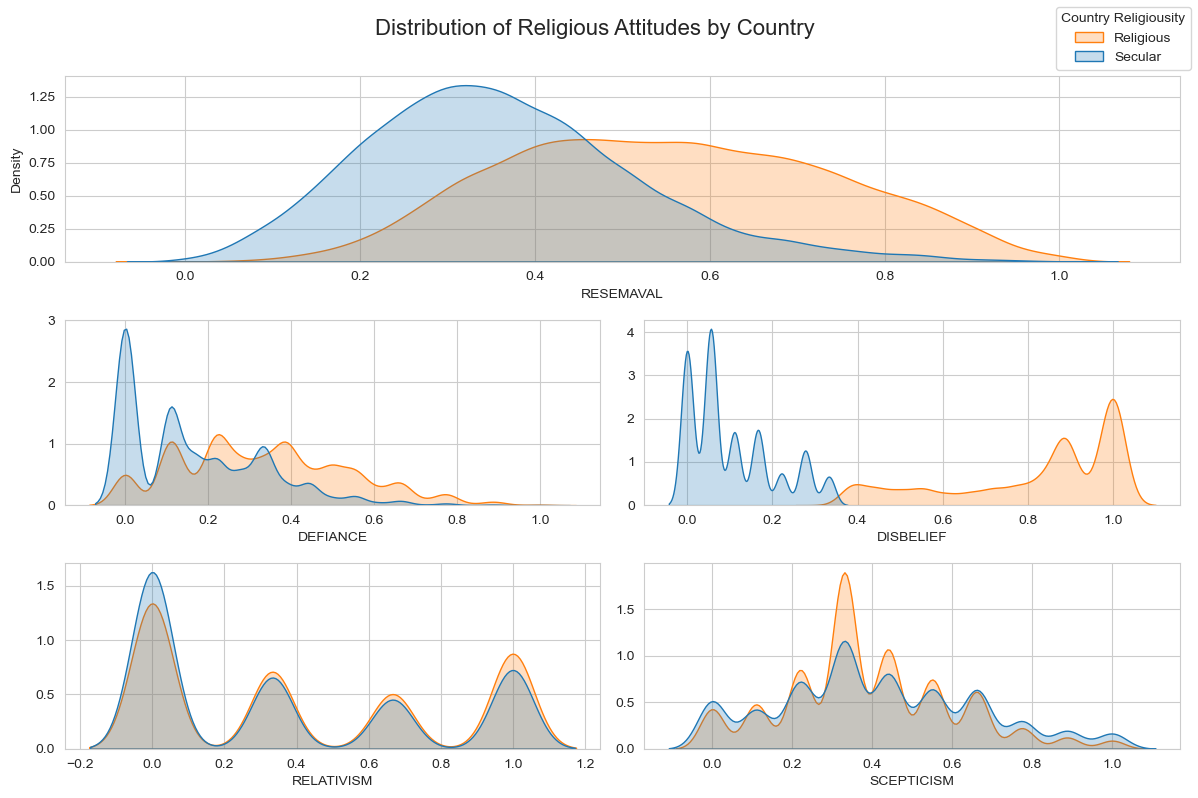

In [15]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(3, 1, 1) 
sns.kdeplot(data=wvs20, x='RESEMAVAL', hue='ReligCountry', fill=True, common_norm=True, legend=False, ax=ax1)



ax2 = fig.add_subplot(3, 2, 3)  
sns.kdeplot(data=wvs20, x='DEFIANCE', hue='ReligCountry', fill=True, common_norm=True, legend=False, ax=ax2)
ax2.set_ylabel("")

ax3 = fig.add_subplot(3, 2, 4) 
sns.kdeplot(data=wvs20, x='DISBELIEF', hue='ReligCountry', fill=True, common_norm=True, legend=False, ax=ax3)
ax3.set_ylabel("")

ax4 = fig.add_subplot(3, 2, 5)  
sns.kdeplot(data=wvs20, x='RELATIVISM', hue='ReligCountry', fill=True, common_norm=True, legend=False, ax=ax4)
ax4.set_ylabel("")

ax5 = fig.add_subplot(3, 2, 6)  
sns.kdeplot(data=wvs20, x='SCEPTICISM', hue='ReligCountry', fill=True, common_norm=True, legend=False, ax=ax5)
ax5.set_ylabel("")
fig.suptitle("Distribution of Religious Attitudes by Country\n", fontsize=16)

fig.legend(['Religious', 'Secular'],title="Country Religiousity")
plt.tight_layout()
plt.show()

In [16]:
reg_cols = ["RESEMAVAL","DISBELIEF","RELATIVISM","SCEPTICISM","AGE","EDUCATION","DEFIANCE"]

In [17]:
save_df = False
if save_df:
    clean_df.to_csv("data/WVS_clean.csv", index=False)

In [18]:
valid_cols = ["B_COUNTRY_ALPHA",'ReligCountry','AGE', 'EDUCATION', 'INCOME_LEVEL',  'DEFIANCE', 'DISBELIEF', 'RELATIVISM', 'SCEPTICISM','RESEMAVAL',]
quantiles = [0.0,0.005,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999,1.]

In [19]:
sec_df[reg_cols].quantile(quantiles)

,RESEMAVAL,DISBELIEF,RELATIVISM,SCEPTICISM,AGE,EDUCATION,DEFIANCE
0.000,0.000000,0.000000,0.000000,0.000000,17.0,0.0,0.000000
0.005,0.163310,0.000000,0.000000,0.000000,18.0,0.0,0.000000
0.050,0.279259,0.055556,0.000000,0.000000,22.0,1.0,0.000000
0.100,0.327593,0.221111,0.000000,0.110000,25.0,2.0,0.110000
0.200,0.395278,0.443333,0.000000,0.220000,32.0,2.0,0.110000
0.300,0.450556,0.665556,0.000000,0.330000,37.0,3.0,0.220000
0.400,0.504213,0.796500,0.071000,0.330000,43.0,3.0,0.276667
0.500,0.555311,0.886667,0.333333,0.330000,48.0,4.0,0.330000
0.600,0.607685,0.886667,0.333333,0.440000,54.0,5.0,0.386667
0.700,0.666250,1.000000,0.666667,0.440000,59.0,6.0,0.443333


In [20]:
relig_df[reg_cols].quantile(quantiles)

,RESEMAVAL,DISBELIEF,RELATIVISM,SCEPTICISM,AGE,EDUCATION,DEFIANCE
0.000,0.000000,0.000000,0.000000,0.000000,18.0,0.0,0.000000
0.005,0.041250,0.000000,0.000000,0.000000,18.0,0.0,0.000000
0.050,0.124583,0.000000,0.000000,0.000000,19.0,0.0,0.000000
0.100,0.165833,0.000000,0.000000,0.110000,21.0,0.0,0.000000
0.200,0.216343,0.000000,0.000000,0.220000,24.0,1.0,0.000000
0.300,0.256250,0.055556,0.000000,0.330000,28.0,1.0,0.000000
0.400,0.293009,0.055556,0.000000,0.330000,30.0,2.0,0.103000
0.500,0.325833,0.055556,0.333333,0.440000,34.0,2.0,0.110000
0.600,0.360417,0.111111,0.333333,0.443333,38.0,3.0,0.166667
0.700,0.399352,0.166667,0.666667,0.553333,43.0,3.0,0.220000


In [21]:
clean_df[reg_cols].quantile(quantiles)

,RESEMAVAL,DISBELIEF,RELATIVISM,SCEPTICISM,AGE,EDUCATION,DEFIANCE
0.000,0.000000,0.000000,0.000000,0.000000,16.0,0.0,0.000000
0.005,0.064508,0.000000,0.000000,0.000000,18.0,0.0,0.000000
0.050,0.166667,0.000000,0.000000,0.000000,20.0,1.0,0.000000
0.100,0.214167,0.023000,0.000000,0.110000,22.0,1.0,0.000000
0.200,0.278981,0.055556,0.000000,0.220000,27.0,2.0,0.000000
0.300,0.328704,0.165556,0.000000,0.330000,31.0,2.0,0.110000
0.400,0.374028,0.222222,0.000000,0.330000,36.0,3.0,0.110000
0.500,0.417147,0.333333,0.333333,0.440000,41.0,3.0,0.220000
0.600,0.463750,0.443333,0.333333,0.440000,46.0,4.0,0.276667
0.700,0.516204,0.611111,0.666667,0.550000,52.0,5.0,0.333333


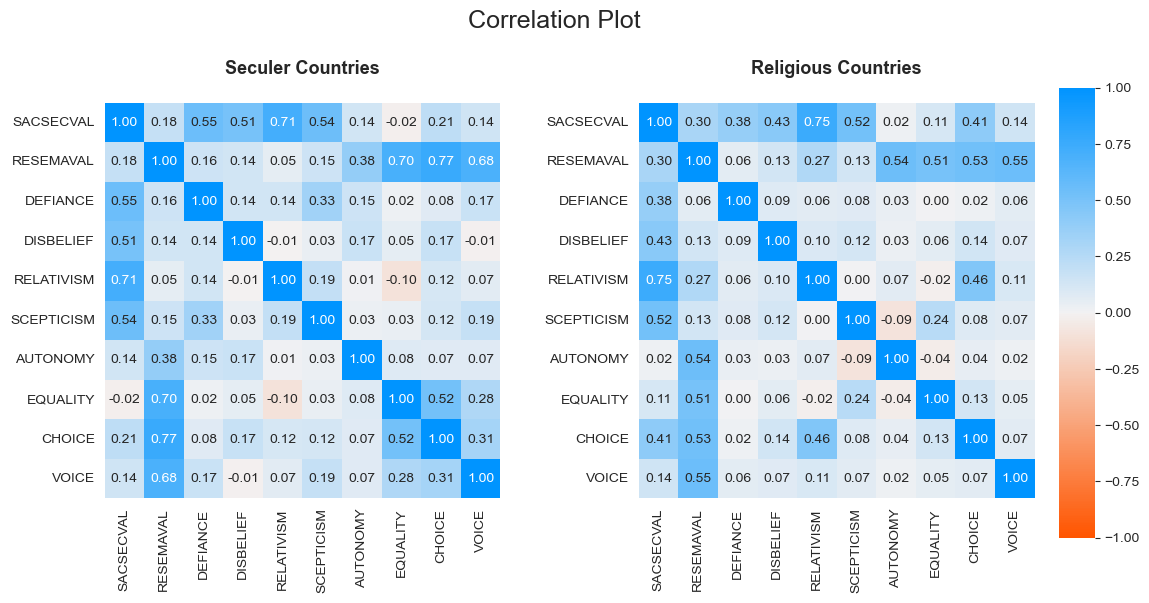

In [46]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={"width_ratios": [1, 1], "wspace": 0.35})

cbar_ax = f.add_axes([0.92, 0.1, 0.03, 0.75]) 
corr_sec = sec_df[cont_cols].corr()
corr_rel = relig_df[cont_cols].corr()
 
shared_cmap = sns.diverging_palette(20, 250, s=105, l=60, as_cmap=True)
sns.heatmap(corr_sec, annot=True,fmt='.2f',cmap=shared_cmap, vmin=-1.0, vmax=1.0,
            square=True, ax=ax[0], cbar=False) 
ax[0].set_title('Seculer Countries\n',fontsize=13,fontweight='bold')

sns.heatmap(corr_rel, annot=True,fmt='.2f', cmap=shared_cmap, vmin=-1.0, vmax=1.0,
            square=True, ax=ax[1], cbar_ax=cbar_ax)
ax[1].set_title('Religious Countries\n',fontsize=13,fontweight='bold')
f.suptitle("Correlation Plot", fontsize=18)
plt.show()